<a href="https://colab.research.google.com/github/itspreeti25/U-NET-implementation-for-segmentation/blob/main/mri_unet-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Wed Apr 21 04:24:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo apt install python3.8

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8-minimal
Suggested packages:
  python3.8-venv python3.8-doc binfmt-support
The following NEW packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8 python3.8-minimal
0 upgraded, 4 newly installed, 0 to remove and 31 not upgraded.
Need to get 4,669 kB of archives.
After this operation, 18.5 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.8-minimal amd64 3.8.9-1+bionic1 [761 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 python3.8-minimal amd64 3.8.9-1+bionic1 [1,823 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.8-stdlib amd64 3.8.9-1+bionic1 [1,656 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.4.1


In [ ]:
!python --version

Python 3.7.10


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.regularizers import l1,l2
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Recall, Precision
from keras.models import load_model

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
import re


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [6]:
data.head(4)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0


In [7]:
data_map = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)


[Errno 20] Not a directory: '/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/data.csv'


In [8]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head(4)
print(len(df))

7868


In [10]:
#separting the image and masks paths into different frames
#removing path like /content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_10 (1).tif

df_imgs = df[~df['path'].str.contains("mask") & ~df['path'].str.contains(pat = '\(1\)', regex = True) ]
df_masks = df[df['path'].str.contains("mask") & ~df['path'].str.contains(pat = '\(1\)', regex = True) ]

# File path line length images for later sorting
BASE_LEN = 110 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)



In [11]:
print(len(df_imgs))
print(len(df_masks))

3929
3929


In [13]:
# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))



In [14]:
# Sorting check
#the output must contain the exact number for image and mask pairs

idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_20.tif 
Path to the Mask: /content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_20_mask.tif


### creating final datset

In [15]:
# Creating Final Dataset(dataframe) 
df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
df['diagnosis'] = df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
df

,patient_id,image_path,mask_path,diagnosis
0,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
1,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
2,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
3,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
4,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
...,...,...,...,...
3924,TCGA_HT_7684_19950816,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
3925,TCGA_HT_7684_19950816,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
3926,TCGA_HT_7684_19950816,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
3927,TCGA_HT_7684_19950816,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0


Text(0.5, 1.05, 'Distribution by diagnosis')

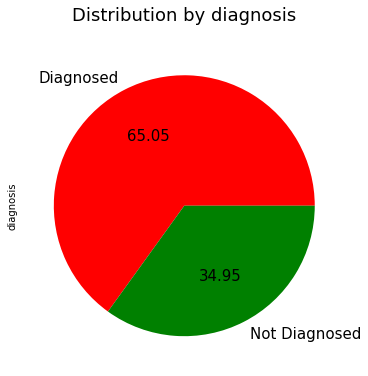

In [19]:
# Plot

axis=df.diagnosis.value_counts().plot.pie( labels=["Diagnosed", "Not Diagnosed"], colors=["red", "green"], autopct="%.2f",fontsize=15,figsize=(6, 6));
axis.set_title("Distribution by diagnosis",fontsize = 18, y=1.05)


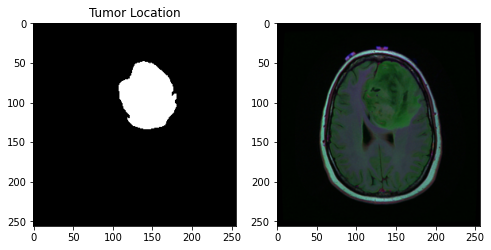

In [27]:
#visualisation of image and its corresponding mask
i=random.randrange(1,len(df))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(df.image_path[i]));

In [28]:
#size of the input image
cv2.imread(df.mask_path[i]).max(), cv2.imread(df.mask_path[i]).min()

(255, 0)

In [29]:
# creating test, train and val sets for segmentation
from sklearn.model_selection import train_test_split

df = pd.DataFrame(data={"mri_scan": df["image_path"], 'mask' : df["mask_path"]})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)


(2828, 2)
(708, 2)
(393, 2)


In [96]:
im_width = 256             #input width size
im_height = 256            #input height size
EPOCHS = 25                #number of time the model will train on the given input
BATCH_SIZE = 16            #batch size to be used per epoch
learning_rate = 1e-4       #learning rate

In [97]:
#defining the generator for the images and masks for yielding values one at a time from the zip folder


def image_mask_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mri_scan",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)


In [98]:
#passing our train and validation datatset to the generator

image_mask_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = image_mask_generator(df_train, BATCH_SIZE,
                                image_mask_generator_args,
                                target_size=(im_height, im_width))
    
val_gen = image_mask_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

In [88]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [61]:
#Implementing a simple UNET model with Endocer as a imagenet model - VGG19 and Decoder for correspondign encoder layers

def unet():
    
    from tensorflow.keras.applications import VGG19
    #clf_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
    inputs = Input(shape=(256,256, 3))
    encoder = VGG19(input_tensor=inputs, weights="imagenet", include_top=False)
    encoder_output = encoder.get_layer("block5_conv4").output #Conv Middle Layer


    #decoder4
    deconv4=UpSampling2D(size=(2,2))(encoder_output)
    uconv4 = encoder.get_layer("block4_conv4").output
    uconv4=Concatenate()([deconv4,uconv4])

    uconv4 = Conv2D(512, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv4)
    uconv4 = BatchNormalization()(uconv4)


    #decoder3
    deconv3=UpSampling2D(size=(2,2))(uconv4)
    uconv3 = encoder.get_layer("block3_conv4").output
    uconv3=Concatenate()([deconv3,uconv3])

    uconv3 = Conv2D(256, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv3)
    uconv3 = BatchNormalization()(uconv3)


    #decoder2
    deconv2=UpSampling2D(size=(2,2))(uconv3)
    uconv2 = encoder.get_layer("block2_conv2").output
    uconv2=Concatenate()([deconv2,uconv2])

    uconv2 = Conv2D(128, (3, 3), activation="relu", padding="same",strides=(1,1))(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv2D(128, (3, 3), activation="relu", padding="same",strides=(1,1))(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    #decoder1
    deconv1=UpSampling2D(size=(2,2))(uconv2)
    uconv1 = encoder.get_layer("block1_conv2").output
    uconv1=Concatenate()([deconv1,uconv1])

    uconv1 = Conv2D(64, (3, 3), activation="relu", padding="same",strides=(1,1))(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv2D(64, (3, 3), activation="relu", padding="same",strides=(1,1))(uconv1)
    uconv1 = BatchNormalization()(uconv1)


    #output layer
    output_final = Conv2D(1, (1, 1),activation="sigmoid", padding='same',strides=(1,1))(uconv1)
    
    return Model(inputs, output_final)

In [99]:
model = unet()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

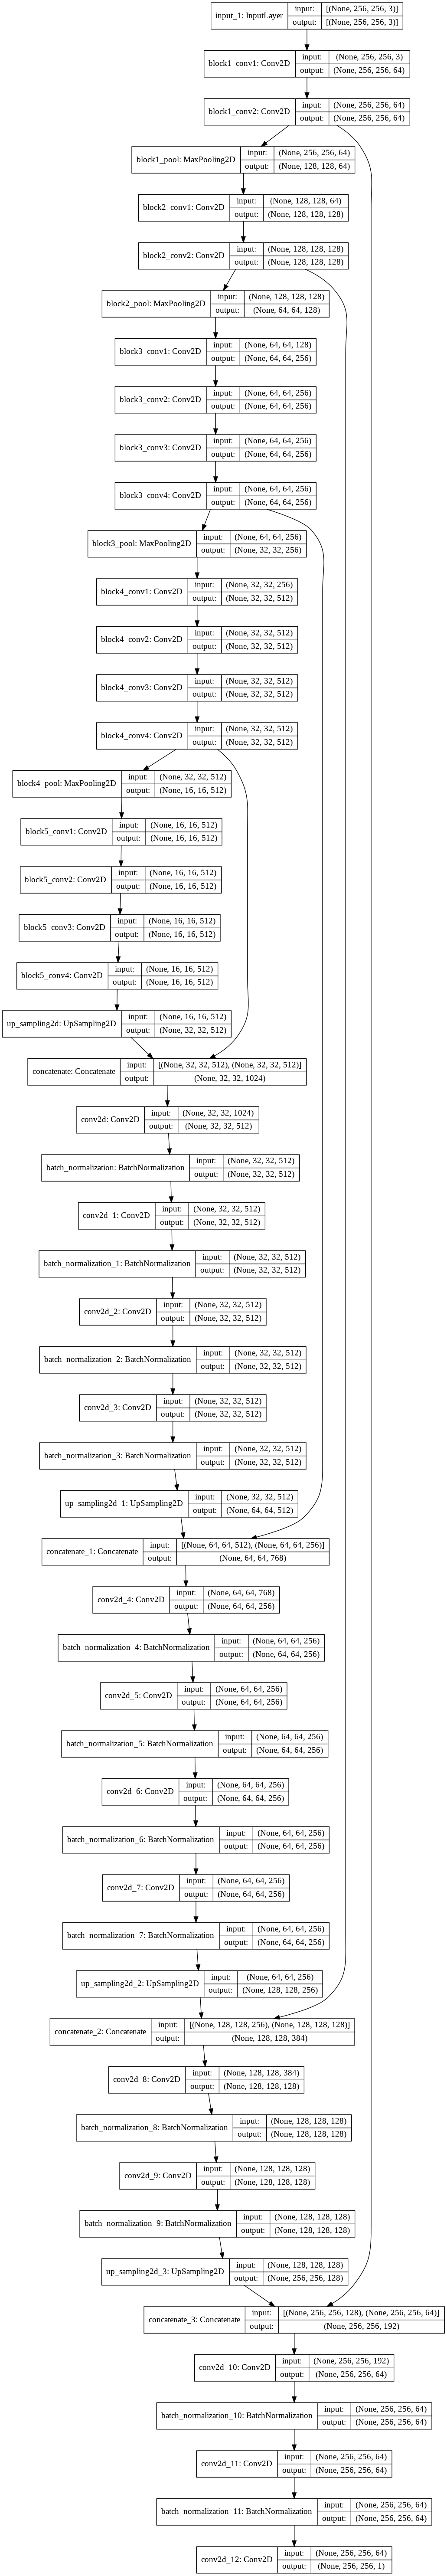

In [38]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [100]:
#Fit the model to the training and validation data


decay_rate = learning_rate / EPOCHS
with tf.device('/device:GPU:0'):
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
    model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

    callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

    history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)




Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/25
177/176 [==============================] - ETA: 0s - loss: -0.0827 - binary_accuracy: 0.7924 - iou: 0.0441 - dice_coef: 0.0827Found 708 validated image filenames.
Found 708 validated image filenames.
176/176 [==============================] - 95s 529ms/step - loss: -0.0829 - binary_accuracy: 0.7928 - iou: 0.0441 - dice_coef: 0.0829 - val_loss: -0.0387 - val_binary_accuracy: 0.7983 - val_iou: 0.0197 - val_dice_coef: 0.0380

Epoch 00001: val_loss improved from inf to -0.03866, saving model to unet_brain_mri_seg.hdf5
Epoch 2/25
176/176 [==============================] - 93s 526ms/step - loss: -0.1570 - binary_accuracy: 0.9312 - iou: 0.0869 - dice_coef: 0.1570 - val_loss: -0.0719 - val_binary_accuracy: 0.7352 - val_iou: 0.0371 - val_dice_coef: 0.0707

Epoch 00002: val_loss improved from -0.03866 to -0.07186, saving model to unet_brain_mri_seg.hdf5
Epoch 3/25
176/176 [==============================] - 96s

In [91]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'iou', 'dice_coef', 'val_loss', 'val_binary_accuracy', 'val_iou', 'val_dice_coef'])

Text(0, 0.5, 'accuracy')

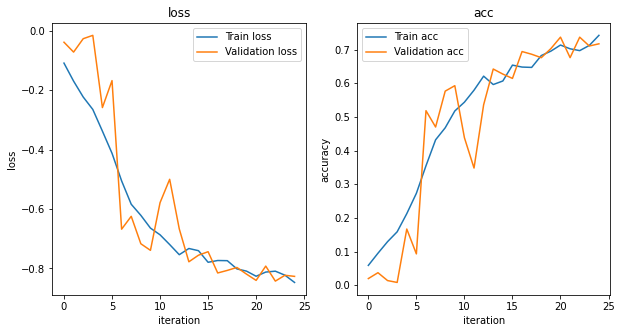

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["iou"], label="Train acc")
ax[1].plot(history.epoch, history.history["val_iou"], label="Validation acc")
ax[1].legend()
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('accuracy')


In [109]:
#validation Accuracy
print("Train Accuracy: " + str(history.history['iou'][-1:]))
print("Validation Accuracy: " + str(history.history['val_iou'][-1:]))

Train Accuracy: [0.7421455979347229]
Validation Accuracy: [0.7170121669769287]


In [110]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
test_gen = image_mask_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 4s 147ms/step - loss: -0.8071 - binary_accuracy: 0.9972 - iou: 0.6882 - dice_coef: 0.8072
Test lost:  -0.8364134430885315
Test IOU:  0.996827244758606
Test Dice Coefficent:  0.7265229821205139


In [115]:
#test accuracy

print("Test Accuracy: ",results[1]*100)

Test Accuracy:  99.6827244758606


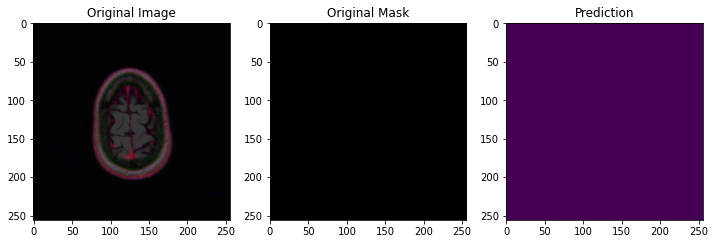

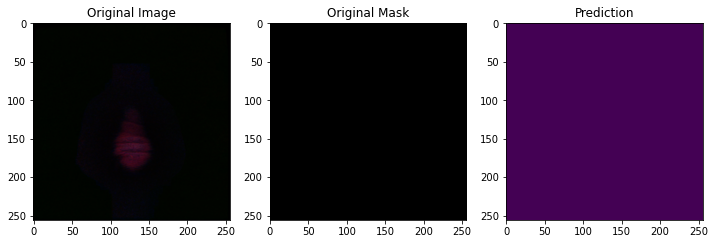

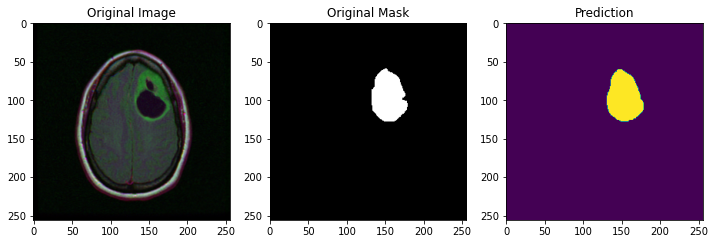

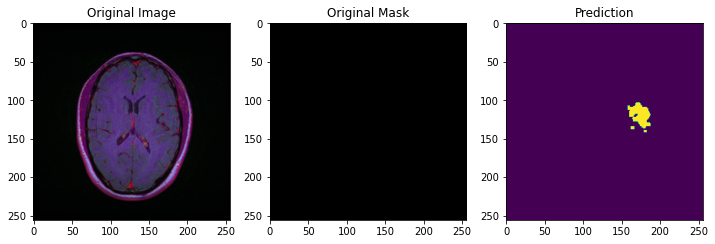

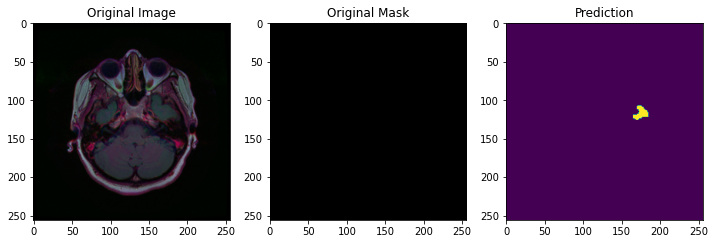

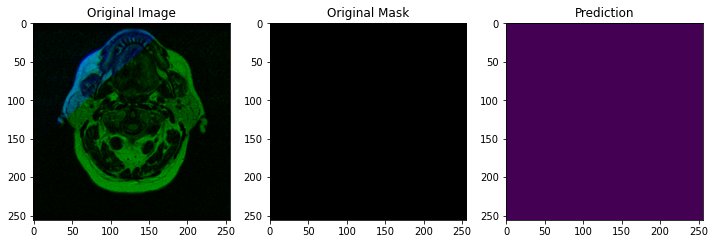

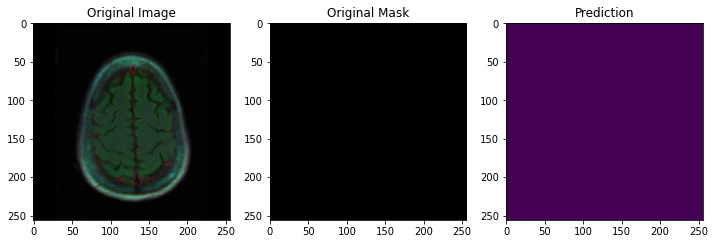

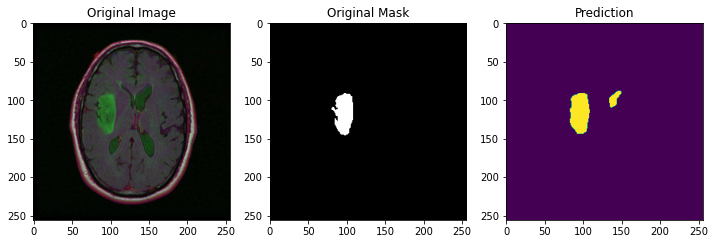

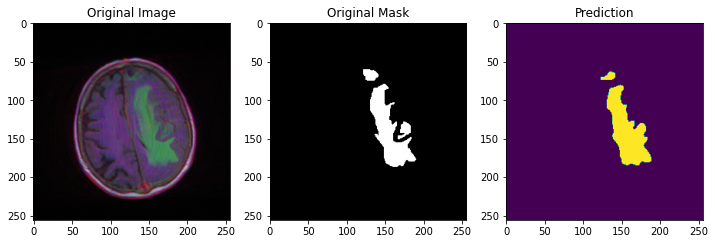

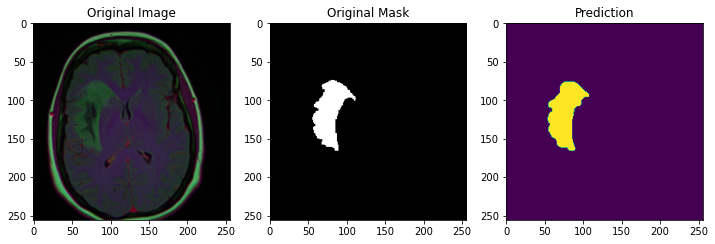

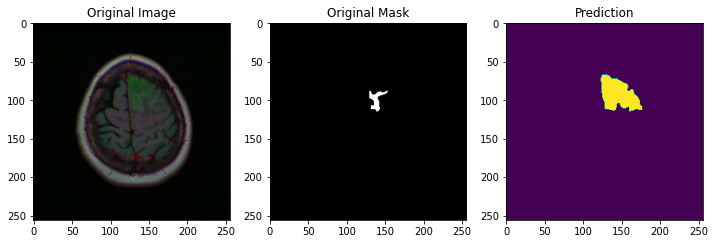

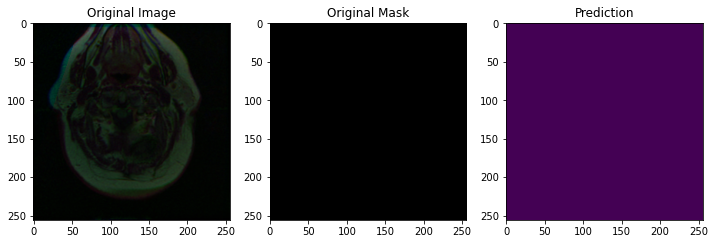

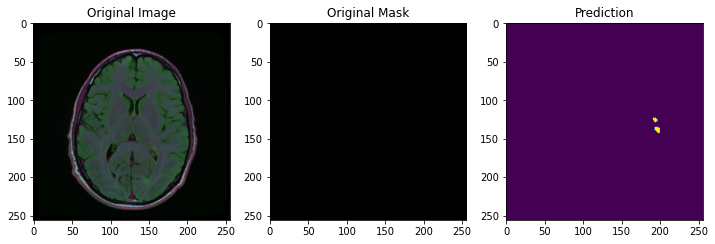

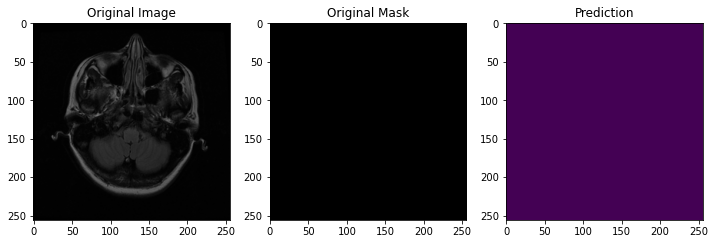

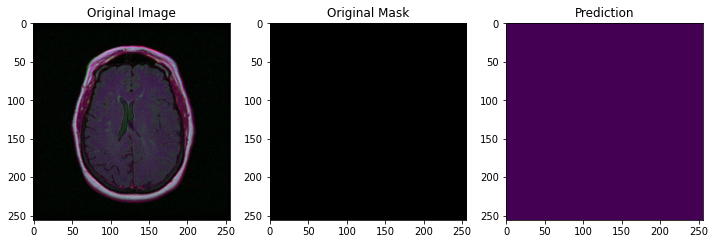

In [119]:
for i in range(15):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['mri_scan'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [120]:
# saving model achitecture in json file
model_json = model.to_json()
with open("unet-model.json", "w") as json_file:
    json_file.write(model_json)